# Mental Illness Classification

<a href="https://colab.research.google.com/drive/15gcNVvhAnTfJlky2mR_s3iPLCfzrO4FJ?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[View Source Code](https://github.com/williamtheodoruswijaya/Deep-Learning-Mental-Health-Analysis) | [View Slides]()

This projects, use model for classification such as:
- Logistic Regressions
- Recurrent Neural Network

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
import joblib
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.utils import resample
import pickle
import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## 2. Dataset reading

2.1 For reading the csv files, we can use pandas that we imported previously.
```py
import pandas as pd
```
The file that were readed will be a dataframes file.

In [2]:
df = pd.read_csv("../data/data.csv")

df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


2.2 Now we can try to get some information from the dataframe using:
```py
df.info()
```

We can understand some information such as:
- How many rows we have
- Null value / NaN values
- Data types for some rows

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


**Conclusions**:
- As you can see, there're Null values in this table since 53043 is the total rows we have and there are only 52681 Non-null values on the statements columns.
- There are also unwanted columns such as "Unnamed" that are having no use for the data learning.

2.3 Drop those Null columns and "Unnamed" Row

In [4]:
df.drop('Unnamed: 0',axis=1,inplace =True)
df.dropna(inplace=True)
df = df[df['statement'] != '']
df.reset_index(drop=True)

df.isnull().sum()

statement    0
status       0
dtype: int64

## 3. Data Preparation

3.1 Data Distributions Plots

We now try to see how does the distributions work on our current dataset.

<Axes: xlabel='status', ylabel='statement'>

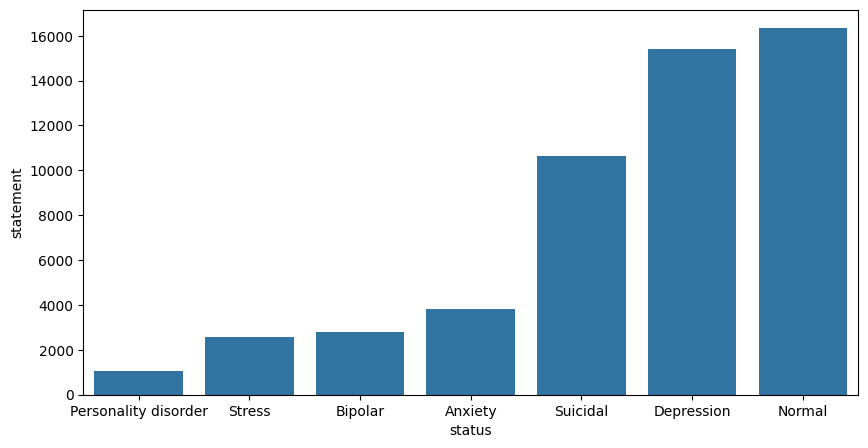

In [5]:
df.replace("", np.nan, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
data = df.groupby('status')['statement'].count().sort_values().reset_index()
plt.figure(figsize = (10,5))
sns.barplot(data=data,x='status',y='statement')

Normal has the most votes! Yet this data distributions appears unbalanced!

Now, Let's describe the data to see what statements appear the most (we also check for duplicates statements)

In [6]:
df.describe()

,statement,status
count,52681,52681
unique,51073,7
top,what do you mean?,Normal
freq,22,16343


From our table here, we can see that normal people asks "what do you mean?" occurs around 22 times, yet it will be irrelevant for us to use that value. But still, duplicates doesn't mean bad for our data.

3.2 Using wordclouds to see how importants each word is

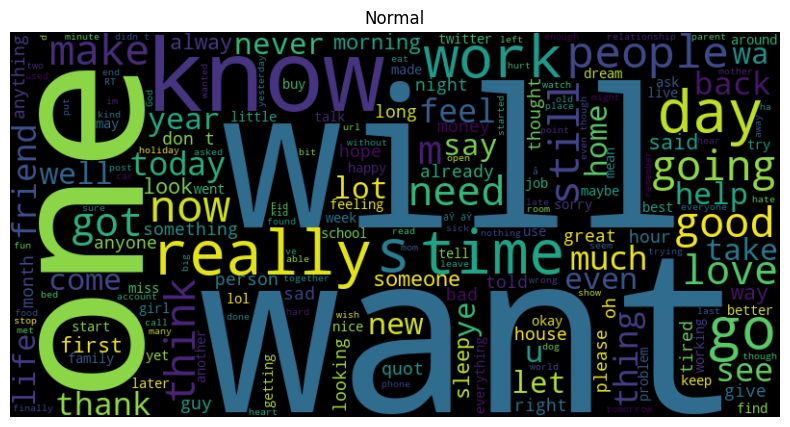

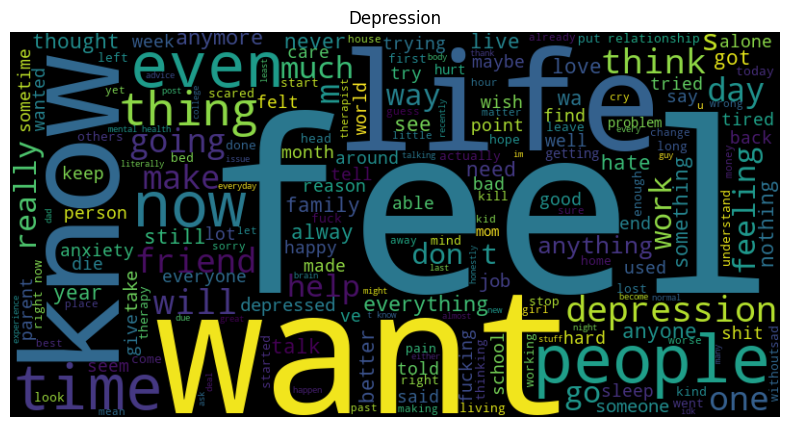

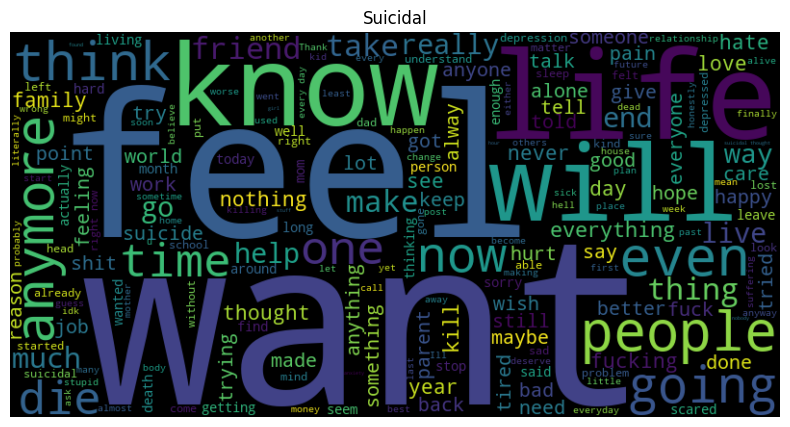

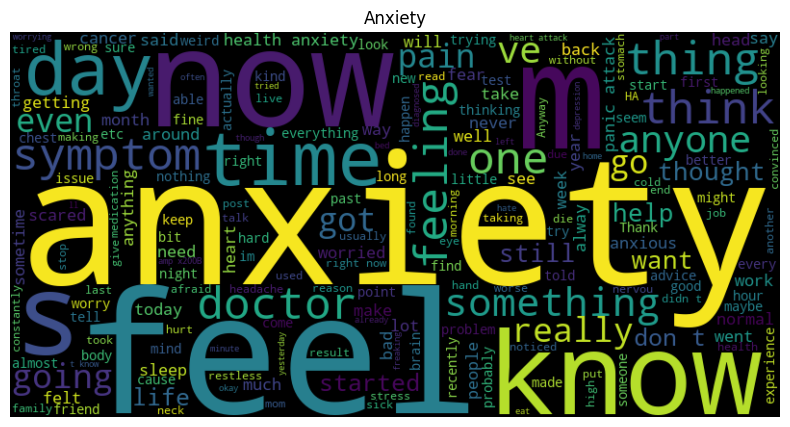

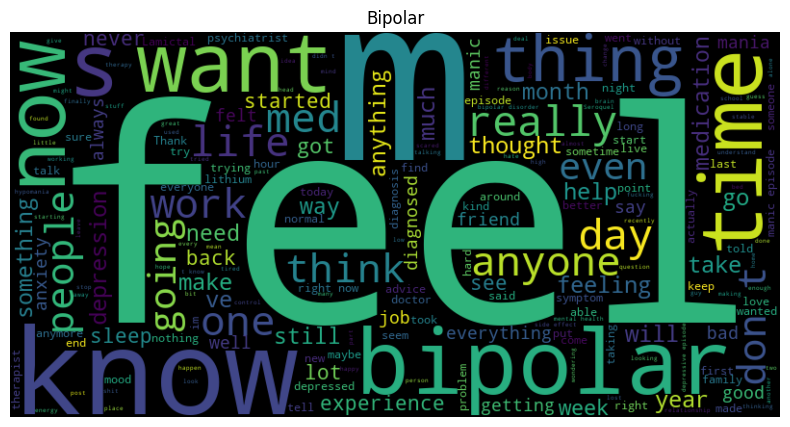

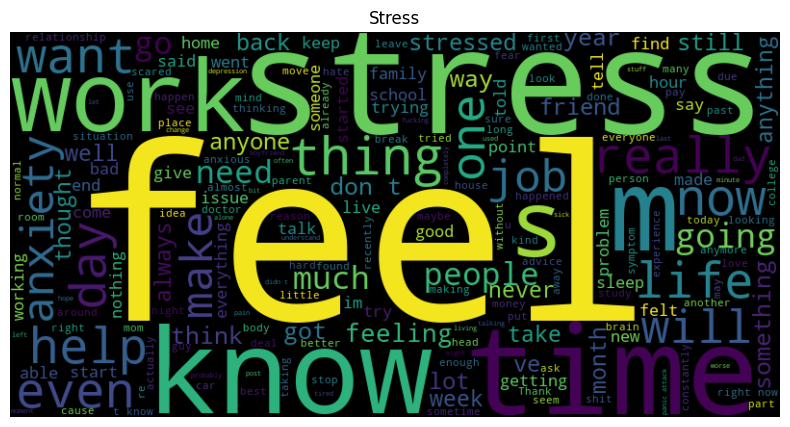

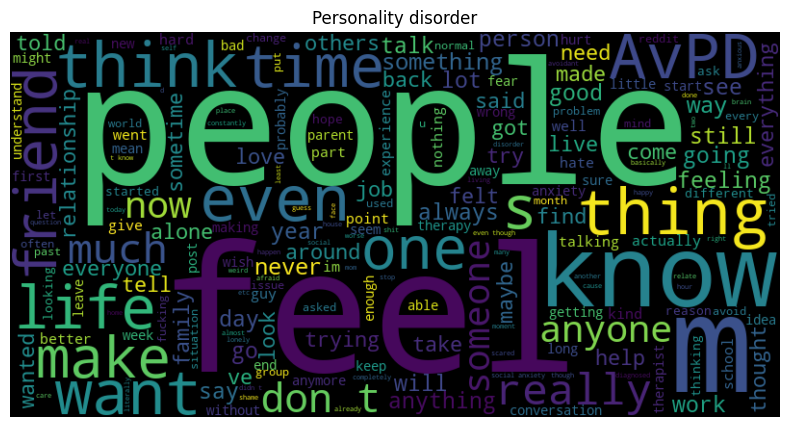

In [7]:
categories = df['status'].value_counts().index

for cat in categories:
    statements = " ".join(df[df['status']==cat]['statement'])

    wordcloud = WordCloud(width=800, height=400).generate(statements)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(cat)
    plt.axis('off')
    plt.show()

## 4. Label Encoding

In [8]:
label_ordered = df['status'].value_counts().index

label_ordered = {k:i for i,k in enumerate(label_ordered,0)}

df['status'] = df['status'].map(label_ordered)

label_ordered

{'Normal': 0,
 'Depression': 1,
 'Suicidal': 2,
 'Anxiety': 3,
 'Bipolar': 4,
 'Stress': 5,
 'Personality disorder': 6}

In [9]:
df.head()

,statement,status
0,oh my gosh,3
1,"trouble sleeping, confused mind, restless hear...",3
2,"All wrong, back off dear, forward doubt. Stay ...",3
3,I've shifted my focus to something else but I'...,3
4,"I'm restless and restless, it's been a month n...",3


## 5. Data Sampling (Balancing Data Distributions)

The purpose of this is to makesure all the data distributions is balanced following the majority size. But since total data is 51073, we'll reduce it into 20000 only. Why?

Because resample() works by creating same random values for data that are less than are our majority size, for instance, if the majority size is 6000 and the data we want to resample size only sized around 2000, then there would be 4000 more data that are the same as those 2000 were. Therefore, we can't risk using the whole 51073 data since that might leads to more duplicates data.

In [10]:
df_sample = df.sample(n=20000,random_state=42)
majority_size = len(df_sample[df_sample['status']==0]) # 0 is the majority class which's normal statements

def resampling(df):
    minority_resample = resample(df,replace=True, n_samples=majority_size, random_state=42)
    return minority_resample

Now, all we need to do is apply the function to all status except the majority_size.

Notes:

Eventhough `resample()` creates a duplicates data, it is still an acceptable trade off rather than using a data with a bad data distributions. The key here is to **avoid excessive duplicates** that's why we reduce the data into 20000 only.

Keep in minds that duplicates are also natural occurences in a data and this kinds of duplicates are acceptable as long as they are not dominating in the dataset.

In [11]:
df_sample_1 = resampling(df_sample[df_sample['status']==1])
df_sample_2 = resampling(df_sample[df_sample['status']==2])
df_sample_3 = resampling(df_sample[df_sample['status']==3])
df_sample_4 = resampling(df_sample[df_sample['status']==4])
df_sample_5 = resampling(df_sample[df_sample['status']==5])
df_sample_6 = resampling(df_sample[df_sample['status']==6])

df_new =pd.concat([df_sample[df_sample['status']==0],df_sample_1,df_sample_2,df_sample_3,df_sample_4,df_sample_5,df_sample_6], axis=0).reset_index(drop=True)
df_new.head()

,statement,status
0,I'm lazy to complain about it ba ihh,0
1,i think the wifi on my iphone is broken it wil...,0
2,that's your favorite thing to do?,0
3,want to sleep but soon the call to prayer for ...,0
4,you use them to wipe the handle of the shoppin...,0


Check the resampled data distributions

<Axes: xlabel='status', ylabel='statement'>

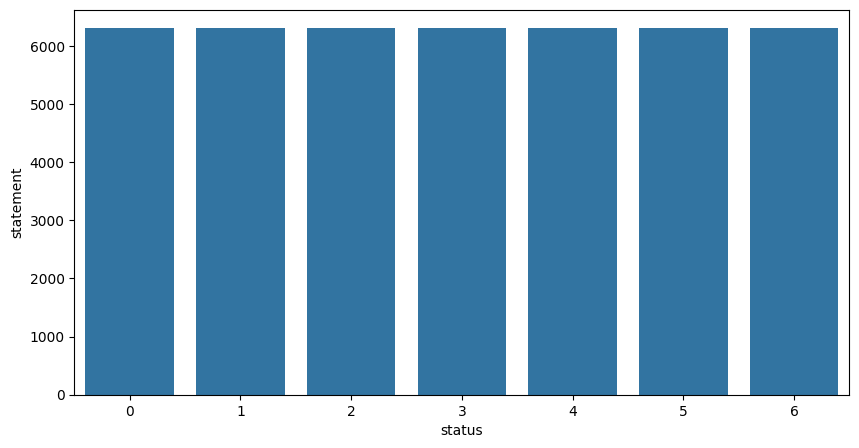

In [12]:
df_new.replace("", np.nan, inplace=True)
df_new.dropna(inplace=True)
df_new.reset_index(drop=True, inplace=True)
data = df_new.groupby('status')['statement'].count().sort_values().reset_index()
plt.figure(figsize = (10,5))
sns.barplot(data=data,x='status',y='statement')

## 6 Data Splitting (80:10:10)

In [13]:
X_train, X_temp, y_train, y_temp = train_test_split(df_new['statement'], df_new['status'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## 8. Logistic Regressions

8.1 Use regex to remove symbols, whitespace, enter, link/url, etc.

In [14]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

df_new['statement'] = df_new['statement'].apply(lambda x: preprocess_text(x))

8.2 Word Tokenization and Using stopwords for better readability for ML Model.

In [15]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df_new['statement'] = df_new['statement'].apply(lambda x: remove_stopwords(x))

8.3 Data Splitting (80:10:10)

In [16]:
X = df_new['statement']
y = df_new['status']

X_train, X_temp, y_train, y_temp = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

8.4 Data Vectorization

for Logistic Regression to works. We simply need the data to be changed into Vector that are the representation of each words. This simply is a way we turns each word into a number that are connected with each other based on its context.

In [17]:
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

8.5 Model Training **(Logistic Regression)**


<a href="https://docs.google.com/spreadsheets/d/1DfyebSF1Q0cS-dkUd13E65yhpCqyBA8_VqcBVYvZwps/edit" target="_parent"><img src=""/>View in Spreadsheet</a>


1. **Logistic Regression Hypothesis**:
   $$
   h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
   $$

2. **Logistic Regression Cost Function**:
   $$
   J(\theta) = -\frac{1}{m} \sum_{i=1}^m \left[ y^{(i)} \log(h_\theta(x^{(i)})) + (1 - y^{(i)}) \log(1 - h_\theta(x^{(i)})) \right]
   $$

3. **Decision Boundary**:
   $$
   h_\theta(x) \geq 0.5 \implies y = 1, \quad h_\theta(x) < 0.5 \implies y = 0
   $$

4. **Sigmoid Function**:
   $$
   \sigma(z) = \frac{1}{1 + e^{-z}}
   $$

5. **Gradient Descent Update Rule**:
   $$
   \theta_j := \theta_j - \alpha \frac{\partial J(\theta)}{\partial \theta_j}, \quad \text{for } j = 0, 1, \ldots, n
   $$

In [18]:
model = LogisticRegression(n_jobs=1, random_state=42)

# Fit the model
model.fit(X_train_tfidf, y_train)

LogisticRegression(n_jobs=1, random_state=42)

8.6 Model Evaluation

In [19]:
accuracy = model.score(X_test_tfidf, y_test)
print(f"Test Accuracy with Logistic Regression: {accuracy}")

y_pred = model.predict(X_test_tfidf)

report = classification_report(y_test, y_pred, target_names=model.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()

styled_report = report_df.style.background_gradient(cmap='coolwarm', axis=0).format(precision=2)
print("Classification Report:")
display(styled_report)

Test Accuracy with Logistic Regression: 0.8895809739524349
Classification Report:


,precision,recall,f1-score,support
0,0.87,0.92,0.89,467.00
1,0.79,0.66,0.72,504.00
2,0.79,0.82,0.81,516.00
3,0.94,0.92,0.93,496.00
4,0.97,0.95,0.96,505.00
5,0.92,0.95,0.94,511.00
6,0.94,1.00,0.97,533.00
accuracy,0.89,0.89,0.89,0.89
macro avg,0.89,0.89,0.89,3532.00
weighted avg,0.89,0.89,0.89,3532.00


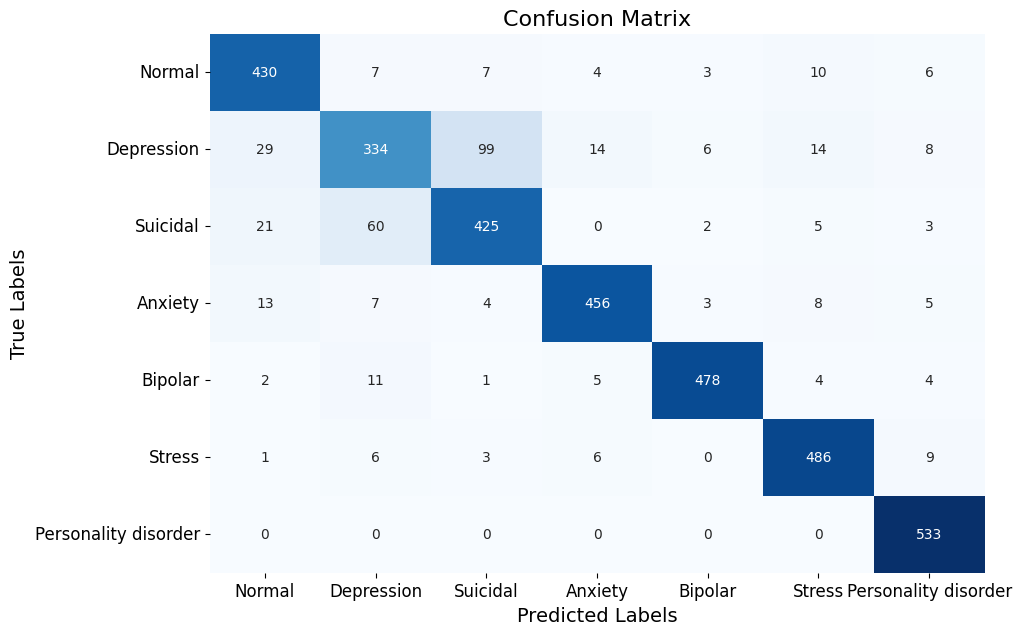

In [20]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_ordered)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=label_ordered, yticklabels=label_ordered)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

8.7 Save the model

In [21]:
with open('../model/logistic-regression/LogisticRegression.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('../model/logistic-regression/tfidfVectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

8.8 Test the model

In [22]:
words = [
    "I feel like nothing matters anymore. Even getting out of bed is a struggle, and I can't see a point to anything.",
    "I often feel like people are trying to control or hurt me, even when they say they care. My emotions swing wildly, and I can't keep stable relationships.",
    "Last week, I felt unstoppable, working day and night on a project without sleep. Now, I can barely find the energy to respond to a text message.",
    "I don't want to be here anymore. Everyone would be better off without me, and I feel like there's no way out of this pain.",
    "My chest tightens every time I think about tomorrow. I keep worrying about things that might go wrong, even if they're small.",
    "I had a good day at work today. It felt productive, and I enjoyed spending time with my colleagues over lunch.",
    "There is so much to do and not enough time to get it all done. I feel like I’m being pulled in every direction and can't relax."
]

model = pickle.load(open('../model/logistic-regression/LogisticRegression.pkl', 'rb'))
vectorizer = pickle.load(open('../model/logistic-regression/tfidfVectorizer.pkl', 'rb'))

words = [preprocess_text(word) for word in words]
words = [remove_stopwords(word) for word in words]

words_tfidf = vectorizer.transform(words)
predictions = model.predict(words_tfidf)

for prediction in predictions:
    print(list(label_ordered.keys())[prediction])

Depression
Normal
Normal
Depression
Normal
Normal
Normal


## 9. Recurrent Neural Network

Now, let us try to use the preprocessed data into a recurrent neural network.

But, since this's a Neural Network, we will need a more advance preprocessing on the data.

9.1 Get the data (we'll use the resampled data for normal data distributions)

In [23]:
df_new.head()

,statement,status
0,im lazy complain ba ihh,0
1,think wifi iphone broken quot connect quot act...,0
2,thats favorite thing,0
3,want sleep soon call prayer midday heavy sleepy,0
4,use wipe handle shopping cart,0


9.2 Preprocess the data

In [24]:
# Dropping empty statement
df_new = df_new[df_new['statement'] != '']

# Dropping whitespace statement
df_new = df_new[df_new['statement'].str.strip() != '']

# Dropping statement with more than 100 words
df_new = df_new[df_new['statement'].apply(lambda x: len(x.split()) <= 100)]

9.3 Get the values into a new variables

In [25]:
train_statements = df_new['statement'].values
train_labels = df_new['status'].values

9.4 Encode the data

1. Create a tokenizer: `tf.keras.preprocessing.text.Tokenizer(...)`
*   Takes only 1000 words that will be kept onto the vocabulary.
*   oov_token: "out of vocabulary" -> use to represent any word that is not part of tokenizer's vocabulary.

2. Apply the sentences: `tokenizer.fit_on_texts(...)`
*   fit_on_texts(): Counts word frequencies in the given text and creates an index where each word is assigned an integer.

3. Convert each sentence into a sequence of integers: `texts_to_sequences(...)`
* Words that are not in the top 10000 most frequent words are replaced by the index for the <OOV> token.

In [26]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000, oov_token='<OOV>')

tokenizer.fit_on_texts(train_statements)

train_sequences = tokenizer.texts_to_sequences(train_statements)

- Optional: Save the trained tokenizer for later deployment

In [27]:
with open('../model/recurrent-neural-network/tokenizer.pkl', 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

9.5 Getting max length of a token for padded sequences making

In [28]:
max_sequence_length = max(len(token) for token in train_sequences)

9.6 Changing train_sequences into padded sequences

Why do we need to pads the sequences?

* Pads the sequences of integers is to ensure they all have the same length: `tf.keras.preprocessing.sequence.pad_sequences(...)`
* `maxlen=500`: Specifies that each sequence will have a maximum length of 500. If a sequence is shorter than 500 words, it will be padded with zeros to make its length 500.
* `padding='post'`: Specifies that the padding (zeros) will be added to the end of each sequence (after the text).

In [29]:
train_pad_sequences = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

train_pad_sequences

array([[  5,   1,   1, ...,   0,   0,   0],
       [ 18,   1,   1, ...,   0,   0,   0],
       [260,   1,  71, ...,   0,   0,   0],
       ...,
       [167,   1, 270, ...,   0,   0,   0],
       [  5, 250, 551, ...,   0,   0,   0],
       [  1, 403, 403, ...,   0,   0,   0]], dtype=int32)

9.7 Label Encoding using One Hot Encoding

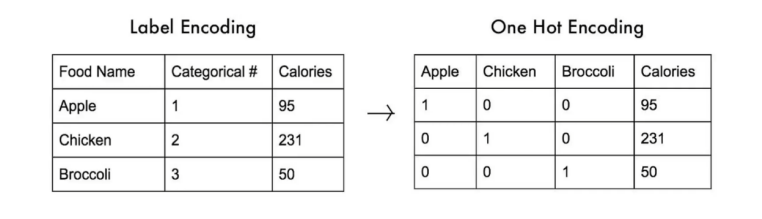

In [30]:
encoder = LabelEncoder()
train_label_arrays = encoder.fit_transform(train_labels)

# One-Hot Encoding
train_label_arrays = tf.keras.utils.to_categorical(train_label_arrays)

train_label_arrays

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

9.8 Shape Checking

In [31]:
train_pad_sequences.shape, train_label_arrays.shape

((35636, 100), (35636, 7))

9.9 Data Splitting (80:10:10)

In [32]:
X_train, X_temp, y_train, y_temp = train_test_split(train_pad_sequences, train_label_arrays, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

9.10 Modelling

- Hyperparameter + Overfitting precautions

> Early Stopping

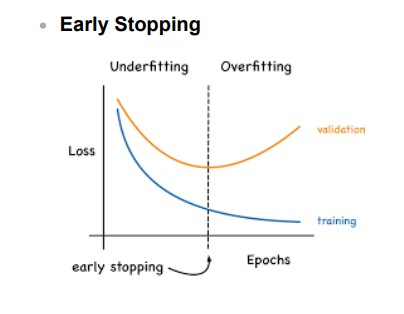

> Learning Rate Scheduler

In [33]:
BATCH_SIZE = 64
EPOCHS = 15
LEARNING_RATE = 0.001
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
LOSS = tf.keras.losses.CategoricalCrossentropy()
METRICS = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
REGULARIZER = tf.keras.regularizers.l2(0.001)
DROPOUT = 0.3

# Overfitting Callbacks
EARLY_STOPPING = tf.keras.callbacks.EarlyStopping(  monitor='val_loss',
                                                    patience=3,
                                                    restore_best_weights=True)
LEARNING_RATE_REDUCE = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                            factor=0.1,
                                                            patience=2,
                                                            verbose=1,
                                                            mode='auto',
                                                            min_delta=0.0001,
                                                            cooldown=0,
                                                            min_lr=0)
MODEL_CHECKPOINT = tf.keras.callbacks.ModelCheckpoint(  'Checkpoint_Model.keras',
                                                        monitor='val_loss',
                                                        verbose=1,
                                                        save_best_only=True)
INPUT_SIZE = np.max([np.max(X_train), np.max(y_train)]) + 1
INPUT_SIZE = int(INPUT_SIZE)

# 4. Deep Learning Model (RNN)

RNN:
- Embedding layer (Acts as **input layer**) --> Changing word into a vector representation of word based on its context in that sentences.
- LSTM Layer (Long-Short-Term-Memory) --> For memorizing text contexts
- Dense Layer (ReLu Activation function)
- Output Layer (Softmax Activation function)

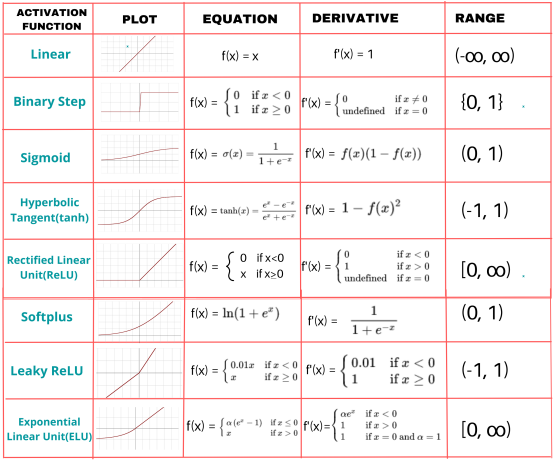

In [34]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=INPUT_SIZE, output_dim=128),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(DROPOUT),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=REGULARIZER),
    tf.keras.layers.Dropout(DROPOUT),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=REGULARIZER),
    tf.keras.layers.Dense(7, activation='softmax')
])

- Compile the model using:

  - Adam for learning-rate optimizer
  - Categorical Crossentropy for loss calculations

In [44]:
model.compile(  optimizer=OPTIMIZER,
                loss=LOSS,
                metrics=METRICS)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │       128,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 98, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 49, 128)        │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,028,183 (3.92 MB)

 Trainable params: 342,727 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 685,456 (2.61 MB)

- Training

In [36]:
history = model.fit(X_train,
                    y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_val, y_val),
                    callbacks=[EARLY_STOPPING, LEARNING_RATE_REDUCE, MODEL_CHECKPOINT])

Epoch 1/15
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.3571 - loss: 1.7162 - precision: 0.6770 - recall: 0.1374
Epoch 1: val_loss improved from inf to 1.01752, saving model to Checkpoint_Model.keras
446/446 ━━━━━━━━━━━━━━━━━━━━ 92s 165ms/step - accuracy: 0.3574 - loss: 1.7157 - precision: 0.6770 - recall: 0.1376 - val_accuracy: 0.6322 - val_loss: 1.0175 - val_precision: 0.7205 - val_recall: 0.5354 - learning_rate: 0.0010
Epoch 2/15
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.7120 - loss: 0.8858 - precision: 0.7784 - recall: 0.6391
Epoch 2: val_loss improved from 1.01752 to 0.63922, saving model to Checkpoint_Model.keras
446/446 ━━━━━━━━━━━━━━━━━━━━ 80s 161ms/step - accuracy: 0.7121 - loss: 0.8856 - precision: 0.7785 - recall: 0.6392 - val_accuracy: 0.7966 - val_loss: 0.6392 - val_precision: 0.8296 - val_recall: 0.7716 - learning_rate: 0.0010
Epoch 3/15
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.8297 - loss: 0.5558 - precision: 0.8559 - recall: 0.

9.11 Model Evaluation

In [38]:
results = model.evaluate(X_test, y_test)
print(f"Test Accuracy with Neural Network: {results[1]}")

report = classification_report(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1), output_dict = True)
report_df = pd.DataFrame(report).transpose()

styled_report = report_df.style.background_gradient(cmap='coolwarm', axis=0).format(precision=2)
print("Classification Report:")
display(styled_report)

112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.9204 - loss: 0.3426 - precision: 0.9231 - recall: 0.9170
Test Accuracy with Neural Network: 0.9250841736793518
112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step
Classification Report:


,precision,recall,f1-score,support
0,0.90,0.89,0.89,636.00
1,0.86,0.79,0.82,458.00
2,0.83,0.88,0.85,542.00
3,0.97,0.98,0.97,443.00
4,0.97,1.00,0.98,470.00
5,0.96,0.98,0.97,565.00
6,1.00,0.98,0.99,450.00
accuracy,0.93,0.93,0.93,0.93
macro avg,0.93,0.93,0.93,3564.00
weighted avg,0.93,0.93,0.92,3564.00


112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step


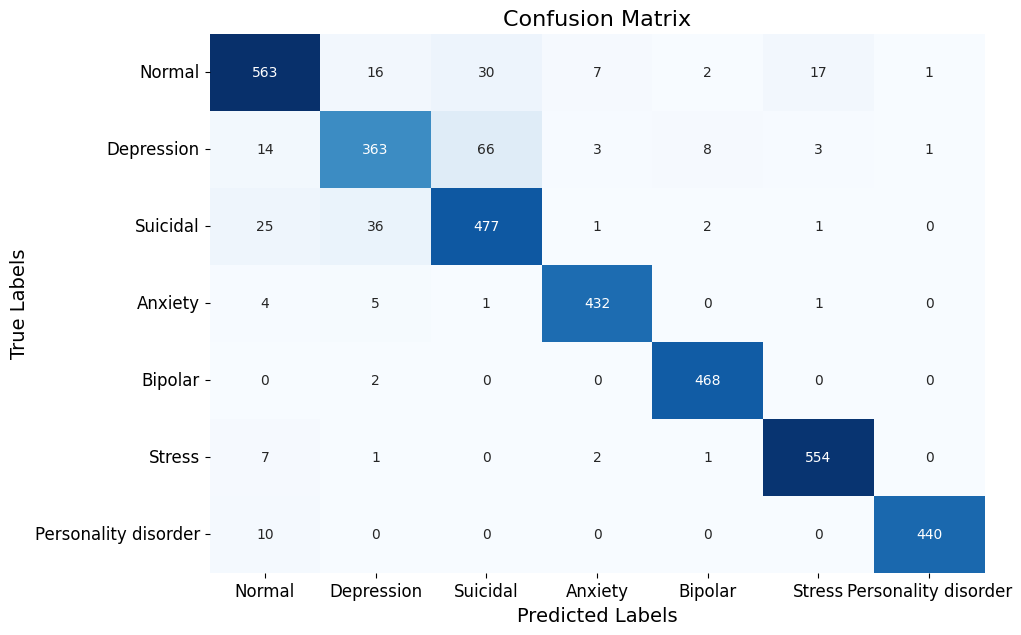

In [39]:
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_ordered)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=label_ordered, yticklabels=label_ordered)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

9.12 Plot the accuracy

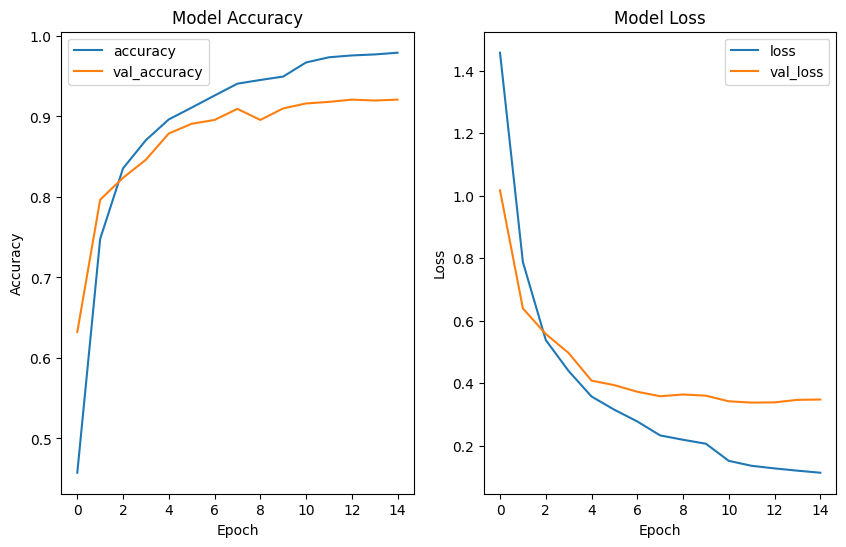

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

9.13 Save the model

In [41]:
model.save('../model/recurrent-neural-network/RNNModel.keras')

In [43]:
words = [
    "I feel like nothing matters anymore. Even getting out of bed is a struggle, and I can't see a point to anything.",
    "I often feel like people are trying to control or hurt me, even when they say they care. My emotions swing wildly, and I can't keep stable relationships.",
    "Last week, I felt unstoppable, working day and night on a project without sleep. Now, I can barely find the energy to respond to a text message.",
    "I don't want to be here anymore. Everyone would be better off without me, and I feel like there's no way out of this pain.",
    "My chest tightens every time I think about tomorrow. I keep worrying about things that might go wrong, even if they're small.",
    "I had a good day at work today. It felt productive, and I enjoyed spending time with my colleagues over lunch.",
    "There is so much to do and not enough time to get it all done. I feel like I’m being pulled in every direction and can't relax."
]

words = [preprocess_text(word) for word in words]
words = [remove_stopwords(word) for word in words]
# load tokenizer
with open('../model/recurrent-neural-network/tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)
words = tokenizer.texts_to_sequences(words)
words = tf.keras.preprocessing.sequence.pad_sequences(words, maxlen=max_sequence_length, padding='post', truncating='post')

model = tf.keras.models.load_model('../model/recurrent-neural-network/RNNModel.keras')
predictions = model.predict(words)
predictions = np.argmax(predictions, axis=1)

for prediction in predictions:
    print(list(label_ordered.keys())[prediction])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Suicidal
Personality disorder
Depression
Suicidal
Anxiety
Normal
Stress
